# Model Comparison: Lead Price 7-Day Return Classification (Baseline)

This notebook compares the performance of all classification models on predicting whether 7-day returns of lead prices will be positive or negative using only price features.

## Models Included:
1. Logistic Regression
2. Random Forest
3. SVM
4. KNN
5. MLP
6. RNN (LSTM)

## Target:
Binary classification: 1 if return_7d > 0, else 0


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Add project root to Python path
try:
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        project_root = current_dir.parent
    else:
        project_root = current_dir
except:
    project_root = Path(r'C:\Project_Macro_Impact_On_Lead')

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

os.chdir(project_root)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Import data splitting function
from src.data.train_test_split_walk_forward import train_test_split_time_series

# Import all classification models
from src.classification.clf_baseline_linear import train_logistic_regression
from src.classification.clf_tree_models import train_random_forest
from src.classification.clf_svm_knn import train_svm, train_knn
from src.classification.clf_mlp import train_mlp
from src.classification.clf_rnn import train_rnn

print("All imports successful")



Bad key text.latex.preview in file c:\Users\34663\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.5/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\Users\34663\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.5/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\Users\34663\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default 

All imports successful


In [2]:
# Load data
df = pd.read_csv("data_processed/lopbdy_features.csv")

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()


Data shape: (6314, 18)
Columns: ['Security', 'LOPBDY LME Comdty', 'returns', 'MA7', 'MA30', 'rolling_volatility', 'EMA5', 'EMA15', 'EMA30', 'MACD5', 'MACD15', 'MACD30', 'RSI', 'BB_upper', 'BB_middle', 'BB_lower', 'return_7d', 'target']


,Security,LOPBDY LME Comdty,returns,MA7,MA30,rolling_volatility,EMA5,EMA15,EMA30,MACD5,MACD15,MACD30,RSI,BB_upper,BB_middle,BB_lower,return_7d,target
0,2025-12-04 00:00:00,1962.0,NaN,1962.000000,1962.000000,NaN,1962.000000,1962.000000,1962.000000,0.000000,0.000000,0.000000,NaN,NaN,1962.000000,NaN,NaN,0
1,2025-12-03 00:00:00,1961.0,-0.000510,1961.500000,1961.500000,NaN,1961.666667,1961.875000,1961.935484,-0.259259,-0.050926,0.009558,0.000000,1962.914214,1961.500000,1960.085786,NaN,0
2,2025-12-02 00:00:00,1965.0,0.002040,1962.666667,1962.666667,0.001803,1962.777778,1962.265625,1962.133195,0.624143,0.111990,-0.020441,80.000000,1966.829999,1962.666667,1958.503335,NaN,0
3,2025-12-01 00:00:00,1946.0,-0.009669,1958.500000,1958.500000,0.006158,1957.185185,1960.232422,1961.092343,-3.771884,-0.724648,0.135274,16.666667,1975.509801,1958.500000,1941.490199,NaN,0
4,2025-11-28 00:00:00,1955.0,0.004625,1957.800000,1957.800000,0.006224,1956.456790,1959.578369,1960.699289,-4.059015,-0.937436,0.183484,39.393939,1972.859880,1957.800000,1942.740120,NaN,0


In [3]:
# Prepare features and target variable
feature_cols = ['returns', 'MA7', 'MA30', 'rolling_volatility']
target_col = 'target'

X = df[feature_cols].values
y = df[target_col].values

# Handle missing values
valid_mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
X = X[valid_mask]
y = y[valid_mask]

print(f"Processed data shape: X={X.shape}, y={y.shape}")
print(f"Features used: {feature_cols}")
print(f"Missing values removed: {len(df) - len(X)} rows")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")
print(f"Target percentage: {y.mean()*100:.2f}% positive (1)")


Processed data shape: X=(6312, 4), y=(6312,)
Features used: ['returns', 'MA7', 'MA30', 'rolling_volatility']
Missing values removed: 2 rows
Target distribution: {0: 3262, 1: 3050}
Target percentage: 48.32% positive (1)


In [4]:
# Time series train-test split
train_X, train_y, test_X, test_y = train_test_split_time_series(X, y, test_size=0.2)

# For fair comparison, align test sets to match RNN requirements
# RNN needs seq_length samples to create sequences, so it skips first (seq_length-1) test samples
seq_length = 10  # Match the seq_length used in RNN
test_X_aligned = test_X[seq_length - 1:]
test_y_aligned = test_y[seq_length - 1:]

print(f"Training set size: {len(train_X)}")
print(f"Original test set size: {len(test_X)}")
print(f"Aligned test set size (for fair comparison): {len(test_X_aligned)}")
print(f"Skipped first {seq_length - 1} test samples to align with sequence models")
print(f"Train/Test ratio: {len(train_X)/len(test_X_aligned):.2f}:1")
print(f"\nTraining target distribution: {pd.Series(train_y).value_counts().to_dict()}")
print(f"Test target distribution: {pd.Series(test_y_aligned).value_counts().to_dict()}")


Training set size: 5050
Original test set size: 1262
Aligned test set size (for fair comparison): 1253
Skipped first 9 test samples to align with sequence models
Train/Test ratio: 4.03:1

Training target distribution: {0: 2580, 1: 2470}
Test target distribution: {0: 674, 1: 579}


## Run All Models

This cell trains all classification models and collects their results.


In [5]:
# Initialize results dictionary
results = {}
model_times = {}

print("=" * 80)
print("Training All Classification Models (Baseline - Price Features Only)")
print("=" * 80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
print(f"Note: All models will evaluate on {len(test_X_aligned)} aligned test samples for fair comparison\n")

# 1. Logistic Regression
print("[1/6] Logistic Regression...", end=" ")
start_time = time.time()
try:
    results['logistic'] = train_logistic_regression(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['logistic'] = elapsed
    print(f"Done (Accuracy: {results['logistic']['accuracy']:.4f}, F1: {results['logistic']['f1']:.4f}, AUC: {results['logistic']['auc']:.4f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 2. Random Forest
print("[2/6] Random Forest...", end=" ")
start_time = time.time()
try:
    results['random_forest'] = train_random_forest(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['random_forest'] = elapsed
    print(f"Done (Accuracy: {results['random_forest']['accuracy']:.4f}, F1: {results['random_forest']['f1']:.4f}, AUC: {results['random_forest']['auc']:.4f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 3. SVM
print("[3/6] SVM...", end=" ")
start_time = time.time()
try:
    results['svm'] = train_svm(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['svm'] = elapsed
    print(f"Done (Accuracy: {results['svm']['accuracy']:.4f}, F1: {results['svm']['f1']:.4f}, AUC: {results['svm']['auc']:.4f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 4. KNN
print("[4/6] KNN...", end=" ")
start_time = time.time()
try:
    results['knn'] = train_knn(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['knn'] = elapsed
    print(f"Done (Accuracy: {results['knn']['accuracy']:.4f}, F1: {results['knn']['f1']:.4f}, AUC: {results['knn']['auc']:.4f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 5. MLP
print("[5/6] MLP...", end=" ")
start_time = time.time()
try:
    results['mlp'] = train_mlp(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['mlp'] = elapsed
    print(f"Done (Accuracy: {results['mlp']['accuracy']:.4f}, F1: {results['mlp']['f1']:.4f}, AUC: {results['mlp']['auc']:.4f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 6. RNN (LSTM)
print("[6/6] RNN (LSTM)...", end=" ")
start_time = time.time()
try:
    results['rnn'] = train_rnn(train_X, train_y, test_X_aligned, test_y_aligned, seq_length=10, epochs=30, verbose=0)
    elapsed = time.time() - start_time
    model_times['rnn'] = elapsed
    print(f"Done (Accuracy: {results['rnn']['accuracy']:.4f}, F1: {results['rnn']['f1']:.4f}, AUC: {results['rnn']['auc']:.4f}, Time: {elapsed:.1f}s)")
except ImportError as e:
    print(f"Import Error: {e}")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

print("\n" + "=" * 80)
print(f"All models completed! End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Successfully trained: {len(results)}/6 models")
print("=" * 80)


Training All Classification Models (Baseline - Price Features Only)
Start time: 2025-12-06 22:16:59

Note: All models will evaluate on 1253 aligned test samples for fair comparison

[1/6] Logistic Regression... Done (Accuracy: 0.6018, F1: 0.6706, AUC: 0.7084, Time: 0.03s)
[2/6] Random Forest... Done (Accuracy: 0.5307, F1: 0.6432, AUC: 0.5822, Time: 0.48s)
[3/6] SVM... Done (Accuracy: 0.5371, F1: 0.6366, AUC: 0.6315, Time: 4.78s)
[4/6] KNN... Done (Accuracy: 0.5595, F1: 0.6373, AUC: 0.6150, Time: 0.04s)
[5/6] MLP... Done (Accuracy: 0.5914, F1: 0.3725, AUC: 0.6526, Time: 0.94s)
[6/6] RNN (LSTM)... Done (Accuracy: 0.8809, F1: 0.8669, AUC: 0.9624, Time: 52.3s)

All models completed! End time: 2025-12-06 22:17:58
Successfully trained: 6/6 models


## Model Performance Comparison Table


In [6]:
# Generate comparison table
if len(results) > 0:
    comparison_data = []
    
    for model_name, result in results.items():
        row = {
            'Model': model_name.replace('_', ' ').title(),
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1'],
            'AUC-ROC': result['auc'] if not np.isnan(result['auc']) else np.nan
        }
        if model_name in model_times:
            row['Training Time (s)'] = f"{model_times[model_name]:.2f}"
        else:
            row['Training Time (s)'] = "N/A"
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
    
    print("=" * 100)
    print("Model Performance Comparison (Sorted by F1-Score - Higher is Better)")
    print("=" * 100)
    print()
    # Format the dataframe for better display
    display_df = comparison_df.copy()
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
    print(display_df.to_string(index=False))
    print()
    print("=" * 100)
    print(f"\nSummary: {len(results)} models successfully trained")
    print(f"Best model (F1-Score): {comparison_df.iloc[0]['Model']} (F1: {comparison_df.iloc[0]['F1-Score']:.4f})")
    print("=" * 100)
else:
    print("Warning: No models were successfully trained. Please check the errors above.")


Model Performance Comparison (Sorted by F1-Score - Higher is Better)

        Model Accuracy Precision Recall F1-Score AUC-ROC Training Time (s)
          Rnn   0.8809    0.8959 0.8397   0.8669  0.9624             52.29
     Logistic   0.6018    0.5427 0.8774   0.6706  0.7084              0.03
Random Forest   0.5307    0.4958 0.9154   0.6432  0.5822              0.48
          Knn   0.5595    0.5143 0.8377   0.6373  0.6150              0.04
          Svm   0.5371    0.4995 0.8774   0.6366  0.6315              4.78
          Mlp   0.5914    0.6414 0.2625   0.3725  0.6526              0.94


Summary: 6 models successfully trained
Best model (F1-Score): Rnn (F1: 0.8669)


## Performance Visualization


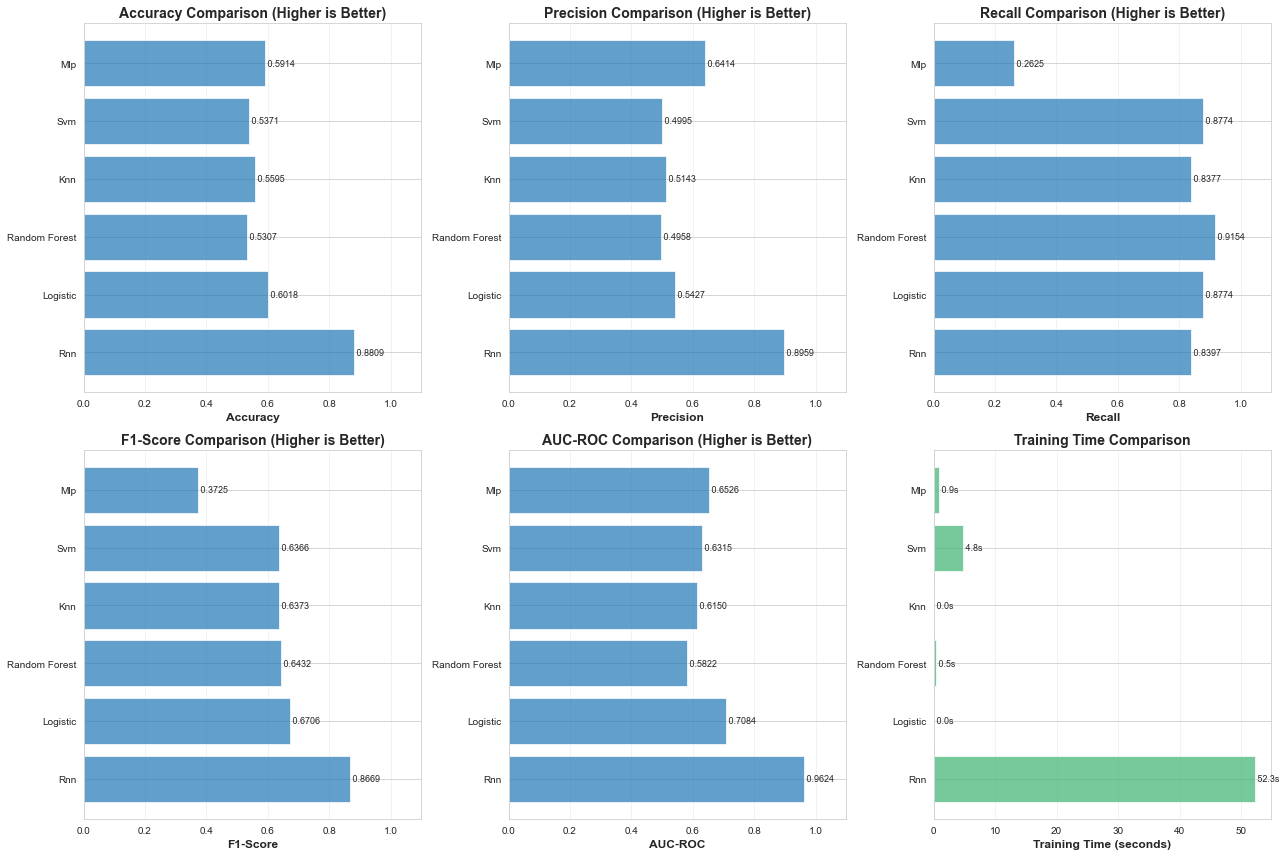


Best Model (F1-Score): Rnn
   Accuracy: 0.8809
   Precision: 0.8959
   Recall: 0.8397
   F1-Score: 0.8669
   AUC-ROC: 0.9624


In [7]:
# Visualize model comparison
if len(results) > 0 and 'comparison_df' in locals():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    models = comparison_df['Model'].values
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    
    # Plot each metric
    for idx, metric in enumerate(metrics_to_plot):
        if idx < len(axes):
            values = comparison_df[metric].values
            # Handle NaN values
            valid_mask = ~np.isnan(values)
            valid_models = models[valid_mask]
            valid_values = values[valid_mask]
            
            if len(valid_values) > 0:
                axes[idx].barh(valid_models, valid_values, alpha=0.7)
                axes[idx].set_xlabel(metric, fontsize=12, fontweight='bold')
                axes[idx].set_title(f'{metric} Comparison (Higher is Better)', fontsize=14, fontweight='bold')
                axes[idx].grid(True, alpha=0.3, axis='x')
                axes[idx].set_xlim([0, 1.1])
                for i, v in enumerate(valid_values):
                    axes[idx].text(v, i, f' {v:.4f}', va='center', fontsize=9)
    
    # Training time comparison (if available)
    time_values = []
    time_labels = []
    for model in models:
        model_key = model.lower().replace(' ', '_')
        if model_key in model_times:
            time_values.append(model_times[model_key])
            time_labels.append(f"{model_times[model_key]:.1f}s")
        else:
            time_values.append(0)
            time_labels.append("N/A")
    
    if any(time_values) and len(axes) > 5:
        axes[5].barh(models, time_values, alpha=0.7, color='mediumseagreen')
        axes[5].set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
        axes[5].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
        axes[5].grid(True, alpha=0.3, axis='x')
        for i, (v, label) in enumerate(zip(time_values, time_labels)):
            if v > 0:
                axes[5].text(v, i, f' {label}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Display best model
    best_model = comparison_df.iloc[0]
    print(f"\nBest Model (F1-Score): {best_model['Model']}")
    print(f"   Accuracy: {best_model['Accuracy']:.4f}")
    print(f"   Precision: {best_model['Precision']:.4f}")
    print(f"   Recall: {best_model['Recall']:.4f}")
    print(f"   F1-Score: {best_model['F1-Score']:.4f}")
    print(f"   AUC-ROC: {best_model['AUC-ROC']:.4f}" if not np.isnan(best_model['AUC-ROC']) else f"   AUC-ROC: N/A")
else:
    print("Warning: Please run the model training cell first to generate visualizations.")


In [30]:
# Debug: Check RNN data alignment and probabilities
if 'rnn' in results:
    rnn_result = results['rnn']
    print("RNN Debug Information:")
    print(f"  y_proba shape: {rnn_result['y_proba'].shape}")
    print(f"  y_pred shape: {rnn_result['y_pred'].shape}")
    print(f"  Stored AUC: {rnn_result.get('auc', 'N/A')}")
    
    # Check what's stored in y_test_aligned
    if 'y_test_aligned' in rnn_result:
        y_test_stored = np.array(rnn_result['y_test_aligned'])
        print(f"  y_test_aligned shape: {y_test_stored.shape}")
        print(f"  y_test_aligned length: {len(y_test_stored.flatten())}")
    else:
        print("  WARNING: y_test_aligned not found in results!")
    
    print(f"  test_y_aligned (from notebook) length: {len(test_y_aligned)}")
    
    # Extract probabilities
    y_proba_raw = rnn_result['y_proba']
    if len(y_proba_raw.shape) > 1:
        y_proba_positive = y_proba_raw[:, 1]
    else:
        y_proba_positive = y_proba_raw
    
    print(f"\n  After extraction:")
    print(f"  y_proba_positive length: {len(y_proba_positive.flatten())}")
    
    if 'y_test_aligned' in rnn_result:
        y_true = np.array(rnn_result['y_test_aligned']).flatten()
        print(f"  y_true (from stored y_test_aligned) length: {len(y_true)}")
        print(f"  Lengths match: {len(y_proba_positive.flatten()) == len(y_true)}")
        
        # Verify AUC
        from sklearn.metrics import roc_auc_score
        y_proba_flat = y_proba_positive.flatten()
        if len(y_proba_flat) == len(y_true):
            recalc_auc = roc_auc_score(y_true, y_proba_flat)
            print(f"  Recalculated AUC: {recalc_auc:.6f}")
            print(f"  Stored AUC: {rnn_result.get('auc', 0):.6f}")
            print(f"  Matches stored AUC: {abs(recalc_auc - rnn_result.get('auc', 0)) < 0.0001}")
        else:
            print(f"  WARNING: Cannot verify AUC - length mismatch!")
else:
    print("RNN results not found. Run model training first.")


RNN Debug Information:
  y_proba shape: (1243, 2)
  y_pred shape: (1243,)
  Stored AUC: 0.962399025015234
  test_y_aligned (from notebook) length: 1253

  After extraction:
  y_proba_positive length: 1243


## ROC Curves Comparison


  Available keys: ['model_name', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'y_pred', 'y_proba']
  Predictions length: 1243
  Using fallback: aligning test_y_aligned to match predictions


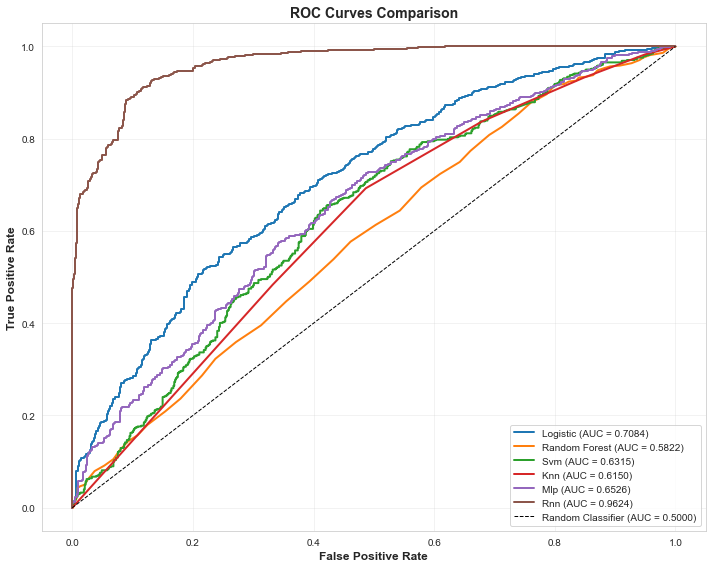

In [33]:
# Plot ROC curves for all models
if len(results) > 0:
    from sklearn.metrics import roc_curve, roc_auc_score
    
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results.items():
        if 'y_proba' in result and result['y_proba'] is not None:
            try:
                y_proba_raw = result['y_proba']
                stored_auc = result.get('auc', np.nan)
                
                # Extract positive class probability - use the EXACT same logic as evaluate_classification
                # (lines 60-62 of evaluate_classification function)
                y_proba_array = np.array(y_proba_raw)
                if len(y_proba_array.shape) > 1:
                    # Exact match: y_proba = y_proba[:, 1] if y_proba.shape[1] > 1 else y_proba.flatten()
                    y_proba_positive = y_proba_array[:, 1] if y_proba_array.shape[1] > 1 else y_proba_array.flatten()
                else:
                    # Already 1D - keep as is for ROC curve (evaluate_classification doesn't flatten 1D)
                    y_proba_positive = y_proba_array
                
                # Get corresponding true labels - use the exact same data used for AUC calculation
                y_proba_positive = y_proba_positive.flatten()
                
                if model_name == 'rnn':
                    # RNN uses sequences which create different alignment
                    # MUST use the stored y_test_aligned (y_test_seq) which matches predictions exactly
                    # DO NOT use test_y_aligned from notebook - it has wrong length (1253 vs 1243)
                    
                    # Check what keys are available in the result
                    available_keys = list(result.keys())
                    
                    if 'y_test_aligned' not in result:
                        # Fallback: Since RNN creates sequences, predictions have fewer samples
                        # The predictions length tells us how many sequences were created
                        pred_len = len(y_proba_positive)
                        seq_length = 10  # Default sequence length used in notebook
                        
                        # RNN sequences skip the first (seq_length-1) samples
                        # So we need to align test_y_aligned by skipping those samples
                        print(f"Warning: RNN y_test_aligned not found in results.")
                        print(f"  Available keys: {available_keys}")
                        print(f"  Predictions length: {pred_len}")
                        print(f"  Using fallback: aligning test_y_aligned to match predictions")
                        
                        # Align test_y_aligned to match predictions
                        # RNN create_sequences: for i in range(len(X_data) - seq_length), 
                        #   target is at y_data[i + seq_length - 1]
                        # So if test_y_aligned has N samples, we get N - seq_length sequences
                        # Targets are at indices: seq_length-1, seq_length, ..., N-1
                        # Therefore: aligned_y = test_y_aligned[seq_length-1:]
                        # And pred_len should equal len(test_y_aligned) - seq_length
                        aligned_y = np.array(test_y_aligned[seq_length - 1:]).flatten()
                        
                        # Truncate to match prediction length (should already match, but be safe)
                        if len(aligned_y) >= pred_len:
                            y_true_for_roc = aligned_y[:pred_len]
                        else:
                            print(f"ERROR: Cannot align - aligned_y length ({len(aligned_y)}) < pred_len ({pred_len})")
                            raise ValueError(f"Cannot align RNN test_y - aligned length too short")
                        
                        if len(y_true_for_roc) != pred_len:
                            print(f"ERROR: Fallback alignment failed - y_true: {len(y_true_for_roc)}, y_proba: {pred_len}")
                            raise ValueError(f"Cannot align RNN test_y - lengths don't match after alignment")
                    else:
                        # Get the stored aligned test_y (should be y_test_seq with length matching predictions)
                        y_true_stored = np.array(result['y_test_aligned'])
                        y_true_for_roc = y_true_stored.flatten()
                        
                        # CRITICAL: The stored y_test_aligned MUST match predictions length (1243)
                        stored_len = len(y_true_for_roc)
                        pred_len = len(y_proba_positive)
                        
                        if stored_len != pred_len:
                            # This is a critical error - stored value should match predictions
                            print(f"\nCRITICAL ERROR: RNN stored y_test_aligned length mismatch!")
                            print(f"  Predictions length: {pred_len}")
                            print(f"  Stored y_test_aligned length: {stored_len}")
                            print(f"  Notebook test_y_aligned length: {len(test_y_aligned)}")
                            print(f"  Difference: {abs(stored_len - pred_len)}")
                            print(f"\n  Attempting fallback alignment...")
                            
                            # Try fallback alignment using the same logic as above
                            seq_length = 10
                            aligned_y = np.array(test_y_aligned[seq_length - 1:]).flatten()
                            
                            if len(aligned_y) >= pred_len:
                                y_true_for_roc = aligned_y[:pred_len]
                                print(f"  Fallback alignment successful! Using aligned test_y_aligned")
                            else:
                                raise ValueError(f"Cannot plot RNN ROC: stored y_test_aligned ({stored_len}) != predictions ({pred_len}) and fallback failed (aligned length {len(aligned_y)} too short)")
                else:
                    # For other models, predictions align with test_y_aligned
                    y_true_for_roc = np.array(test_y_aligned).flatten()
                
                # Verify lengths match (should be exact for RNN)
                if len(y_proba_positive) != len(y_true_for_roc):
                    if model_name == 'rnn':
                        # For RNN, this is a critical error
                        raise ValueError(f"RNN alignment error: y_proba ({len(y_proba_positive)}) != y_true ({len(y_true_for_roc)})")
                    else:
                        # For other models, truncate if needed
                        print(f"Warning: {model_name} length mismatch - y_proba: {len(y_proba_positive)}, y_true: {len(y_true_for_roc)}. Truncating to match.")
                        min_len = min(len(y_proba_positive), len(y_true_for_roc))
                        y_proba_positive = y_proba_positive[:min_len]
                        y_true_for_roc = y_true_for_roc[:min_len]
                
                # Calculate ROC curve using the exact same data that was used for AUC
                if len(y_proba_positive) > 0 and len(y_proba_positive) == len(y_true_for_roc):
                    # Verify the calculated AUC matches stored AUC before plotting
                    calculated_auc = roc_auc_score(y_true_for_roc, y_proba_positive)
                    
                    # For RNN, if AUC doesn't match, we might be using wrong column - try both
                    if model_name == 'rnn' and not np.isnan(stored_auc):
                        auc_diff = abs(calculated_auc - stored_auc)
                        if auc_diff > 0.001:
                            # Try using column 0 instead (in case probabilities are inverted)
                            if len(y_proba_array.shape) > 1 and y_proba_array.shape[1] > 1:
                                y_proba_alt = y_proba_array[:, 0].flatten()
                                calculated_auc_alt = roc_auc_score(y_true_for_roc, y_proba_alt)
                                if abs(calculated_auc_alt - stored_auc) < auc_diff:
                                    print(f"Note: Using alternative probability extraction for RNN (AUC diff: {abs(calculated_auc_alt - stored_auc):.6f})")
                                    y_proba_positive = y_proba_alt
                                    calculated_auc = calculated_auc_alt
                    
                    fpr, tpr, _ = roc_curve(y_true_for_roc, y_proba_positive)
                    
                    # Use stored AUC for label (since it was calculated during training)
                    auc = stored_auc if not np.isnan(stored_auc) else calculated_auc
                    
                    label = f"{model_name.replace('_', ' ').title()}"
                    if not np.isnan(auc):
                        label += f" (AUC = {auc:.4f})"
                    else:
                        label += " (AUC = N/A)"
                    
                    plt.plot(fpr, tpr, label=label, linewidth=2)
                else:
                    print(f"Warning: Skipping ROC curve for {model_name} - invalid data: y_proba={len(y_proba_positive)}, y_true={len(y_true_for_roc)}")
            except Exception as e:
                print(f"Warning: Could not plot ROC curve for {model_name}: {str(e)}")
                import traceback
                traceback.print_exc()
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1)
    
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: Please run the model training cell first to generate ROC curves.")


## Confusion Matrices


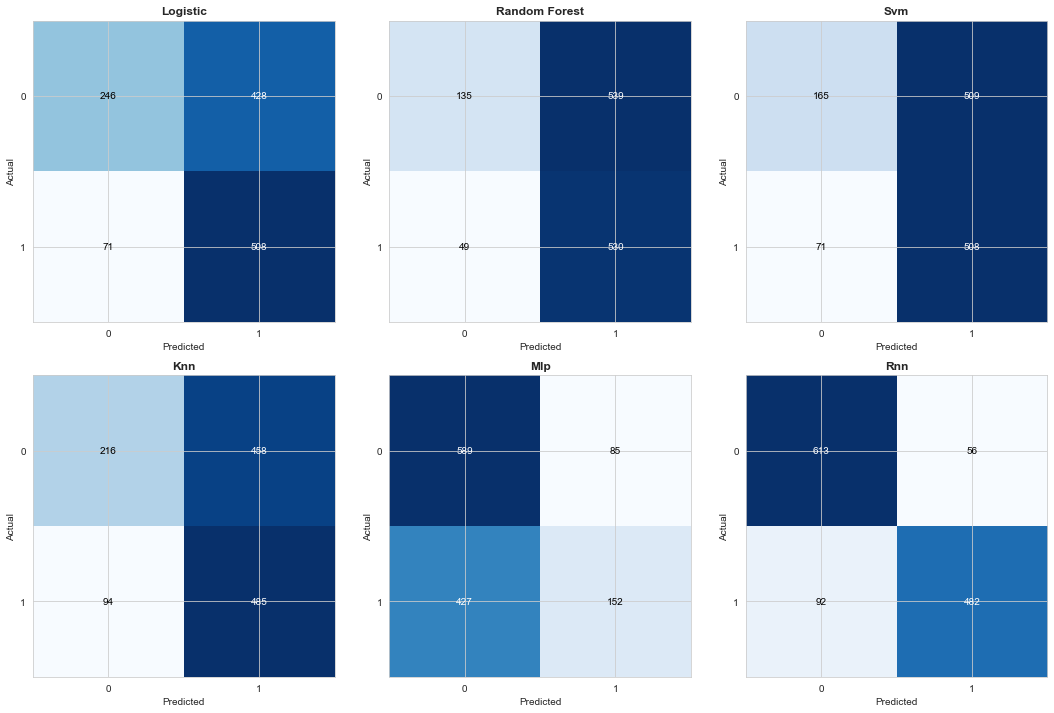

In [34]:
# Plot confusion matrices for all models
if len(results) > 0:
    from sklearn.metrics import confusion_matrix
    
    n_models = len(results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (model_name, result) in enumerate(results.items()):
        if idx < len(axes):
            y_pred = result['y_pred']
            
            # Get corresponding true labels - use the same logic as ROC plotting
            if model_name == 'rnn':
                # RNN uses sequences which create different alignment
                if 'y_test_aligned' in result:
                    y_true_for_cm = np.array(result['y_test_aligned']).flatten()
                else:
                    # Fallback alignment for RNN
                    seq_length = 10
                    pred_len = len(y_pred)
                    aligned_y = np.array(test_y_aligned[seq_length - 1:]).flatten()
                    if len(aligned_y) >= pred_len:
                        y_true_for_cm = aligned_y[:pred_len]
                    else:
                        y_true_for_cm = test_y_aligned  # Last resort
            else:
                # For other models, predictions align with test_y_aligned
                y_true_for_cm = np.array(test_y_aligned).flatten()
            
            # Ensure lengths match
            if len(y_pred) != len(y_true_for_cm):
                min_len = min(len(y_pred), len(y_true_for_cm))
                y_pred = y_pred[:min_len]
                y_true_for_cm = y_true_for_cm[:min_len]
            
            cm = confusion_matrix(y_true_for_cm, y_pred)
            
            # Use matplotlib imshow instead of seaborn to avoid NumPy compatibility issues
            im = axes[idx].imshow(cm, interpolation='nearest', cmap='Blues')
            
            # Add text annotations
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    axes[idx].text(j, i, format(cm[i, j], 'd'),
                                 ha="center", va="center",
                                 color="white" if cm[i, j] > thresh else "black")
            
            axes[idx].set_title(f"{model_name.replace('_', ' ').title()}", fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Actual')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_xticks(range(cm.shape[1]))
            axes[idx].set_yticks(range(cm.shape[0]))
    
    # Hide extra subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Warning: Please run the model training cell first to generate confusion matrices.")
